# Data mining of social networks
## Girvan Newman Algorithm

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import copy

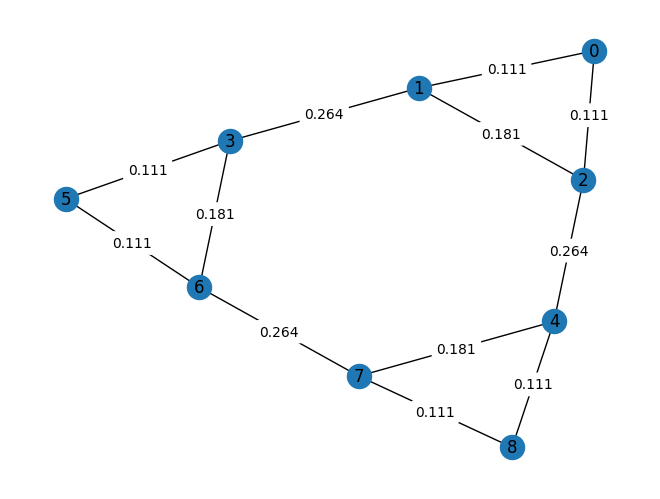

In [2]:
g = nx.bull_graph()
g.add_edges_from([(3,5), (3,6), (5,6), (4,7), (4,8), (7,8), (6,7)])
betwenness = nx.edge_betweenness(g)
labels = {edge: f'{bwns:.3f}' for edge, bwns in betwenness.items()}

pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, rotate=False);

In [3]:
def remove_edges(g, treshold):
  betwenness = nx.edge_betweenness(g)
  edges_to_remove = filter(lambda e: betwenness[e] >= treshold, betwenness.keys())
  g.remove_edges_from(edges_to_remove)

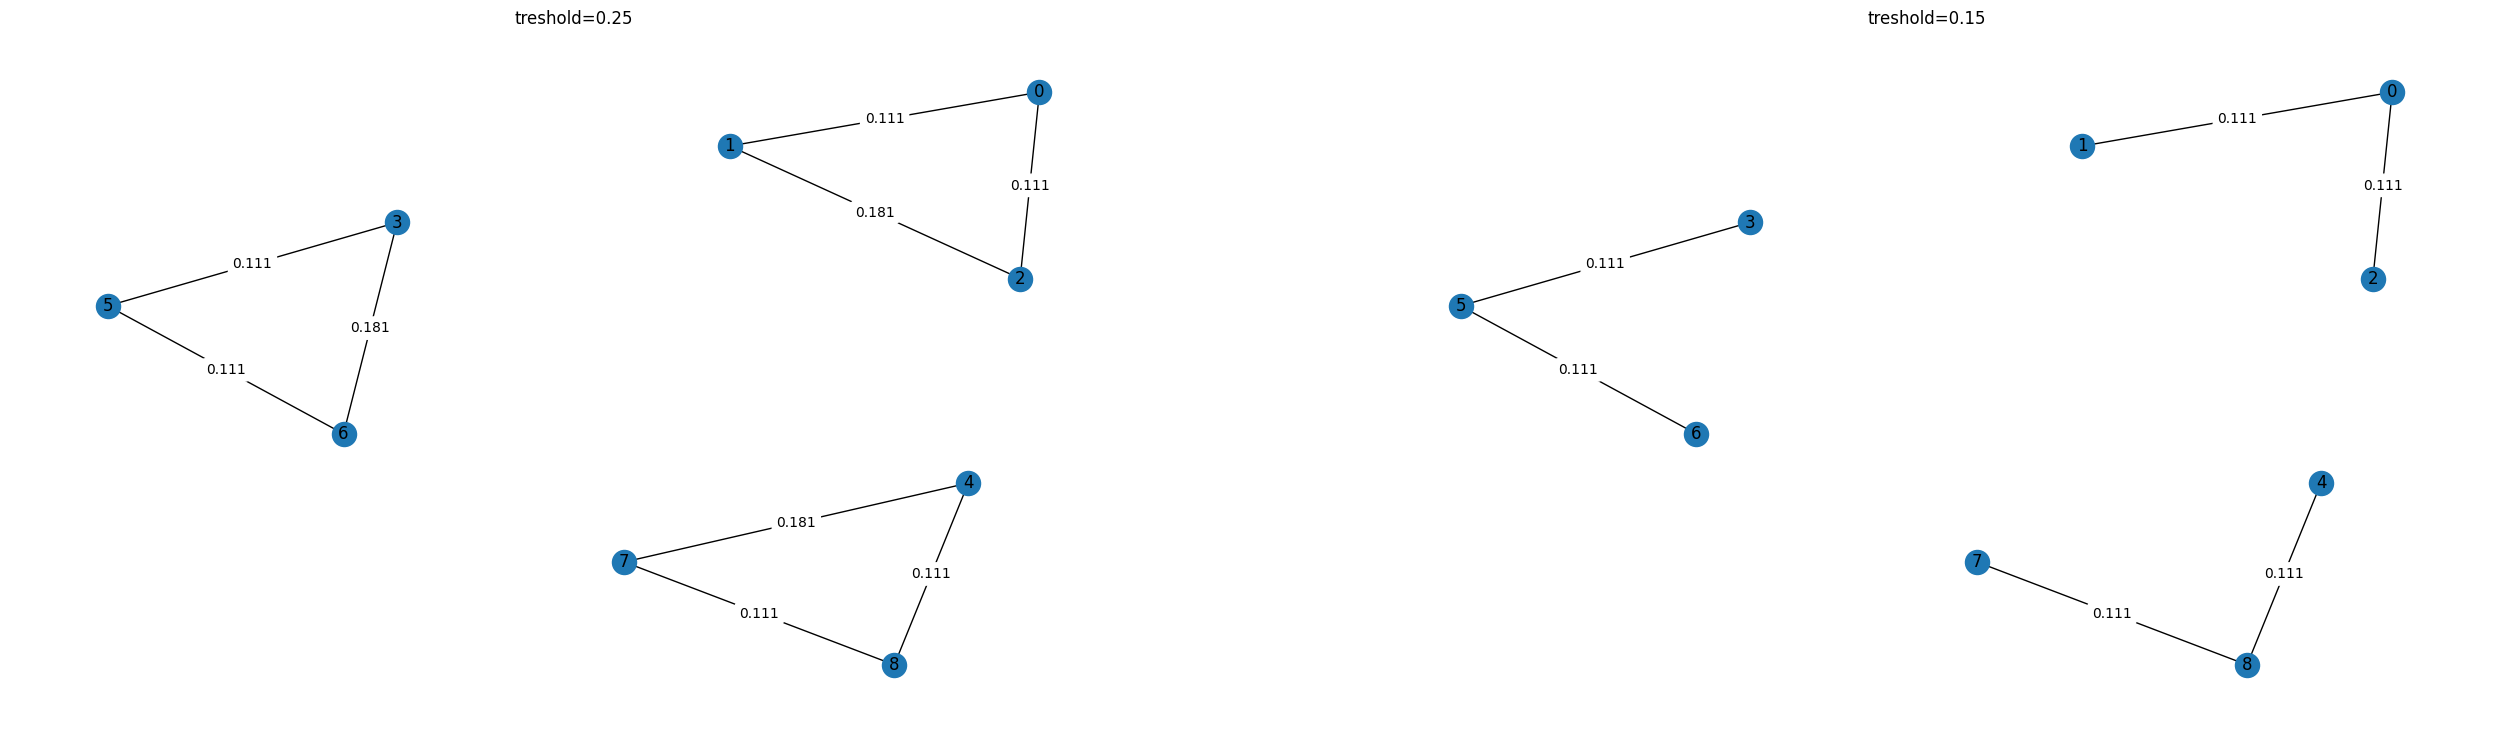

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(32, 9))

g1 = g.copy()
treshold = .25
remove_edges(g1, treshold)
labels = {e: labels[e] for e in g1.edges()}
ax = axs[0]
ax.set_title(f'treshold={treshold}')
nx.draw(g1, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(g1, pos, edge_labels=labels, rotate=False, ax=ax)

g2 = g.copy()
treshold = .15
remove_edges(g2, treshold)
labels = {e: labels[e] for e in g2.edges()}
ax = axs[1]
ax.set_title(f'treshold={treshold}')
nx.draw(g2, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(g2, pos, edge_labels=labels, rotate=False, ax=ax);


In [5]:
def max_betwenness_edge(g):
    centrality = nx.edge_betweenness(g)
    return max(centrality, key=centrality.get)
  
def sep_into_two_communities(g):
    a = nx.connected_components(g)
    while (len(list(a)) == 1):
        u, v = max_betwenness_edge(g)
        g.remove_edge(u, v) 
        a = nx.connected_components(g)
    return a

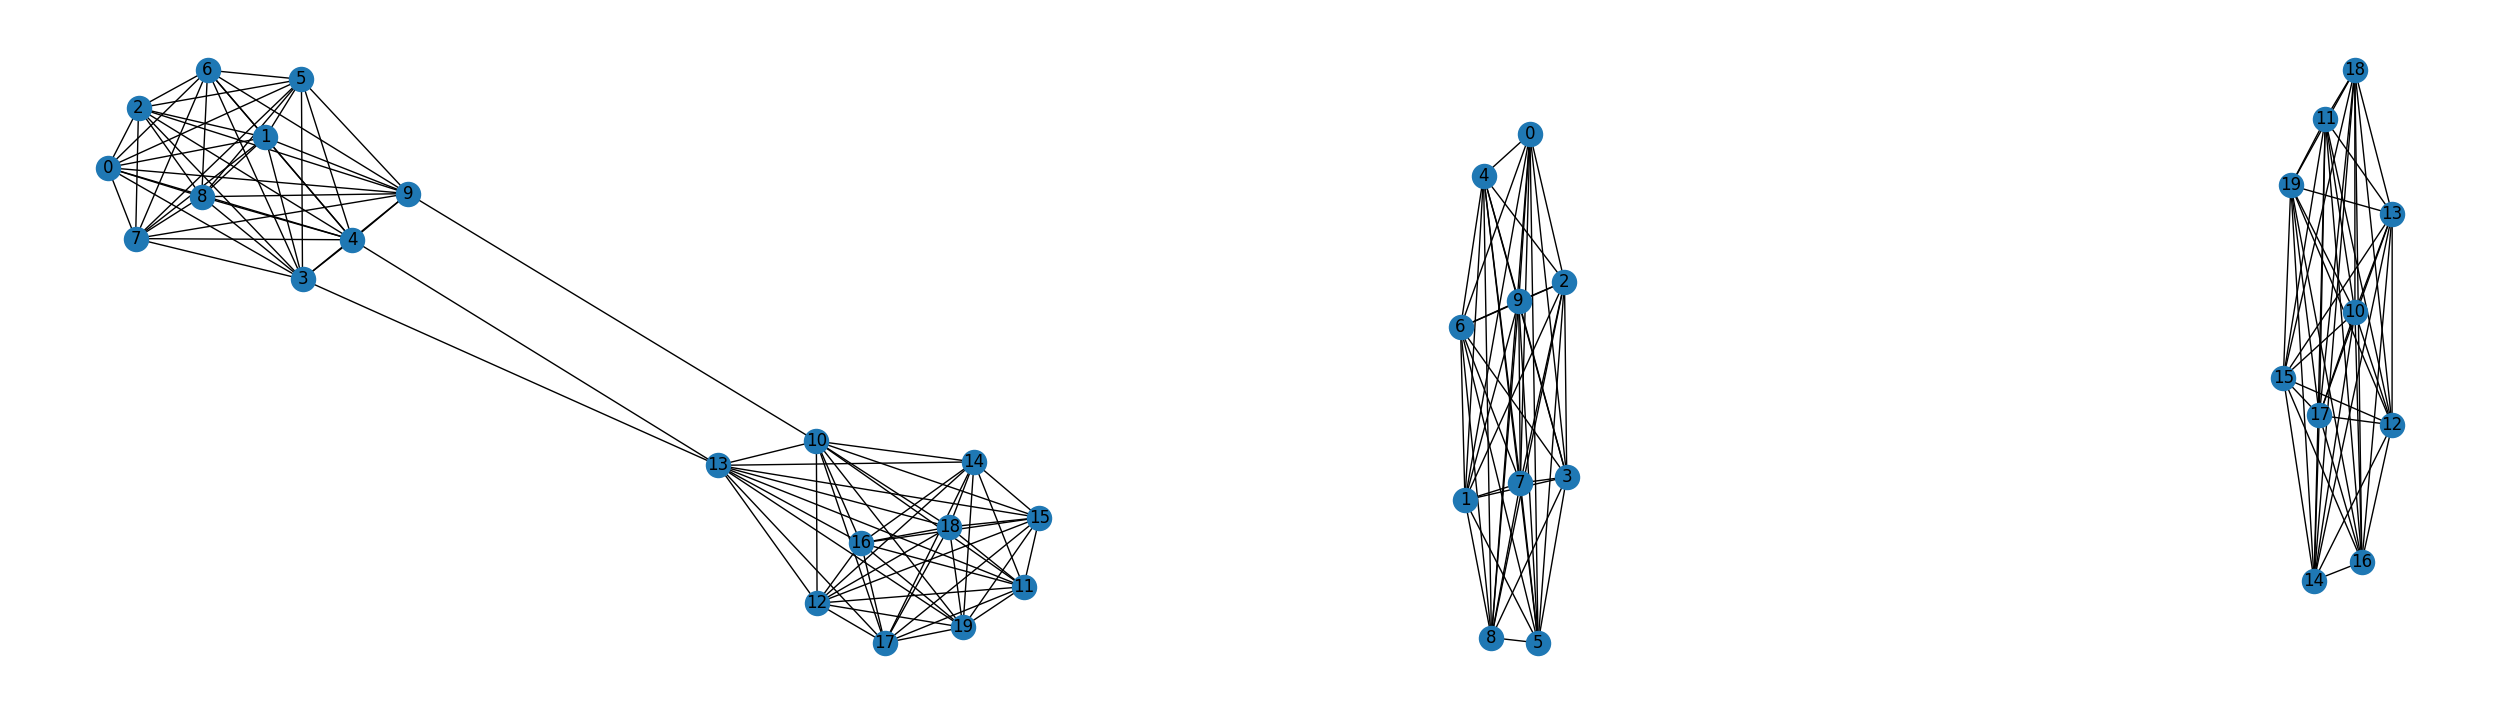

In [6]:
# The original graph
g = nx.barbell_graph(10, 0)
g.add_edge(3, 13)
g.add_edge(4, 13)
plt.figure(1, figsize=(32, 9))
plt.subplot(1, 2, 1)
nx.draw(g, with_labels = True)

# Cluster nodes
a = sep_into_two_communities(g)
plt.subplot(1, 2, 2)
nx.draw(g, with_labels=True)

## Normalised Min Cut Algorithm

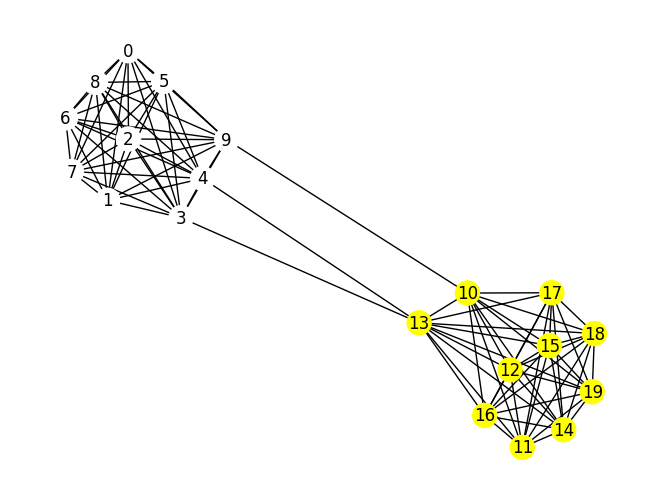

In [7]:
def normalized_min_cut(graph):
    m_adjacency = np.array(nx.to_numpy_matrix(graph))

    D = np.diag(np.sum(m_adjacency, 0))
    D_half_inv = np.diag(1.0 / np.sqrt(np.sum(m_adjacency, 0)))
    M = np.dot(D_half_inv, np.dot((D - m_adjacency), D_half_inv))

    (w, v) = np.linalg.eig(M)
    #find index of second smallest eigenvalue
    index = np.argsort(w)[1]

    v_partition = v[:, index]
    v_partition = np.sign(v_partition)   
    return v_partition

g = nx.barbell_graph(10, 0)
g.add_edge(3, 13)
g.add_edge(4, 13)

a = normalized_min_cut(g)
colors = np.zeros((len(a), 3)) + 1.0
colors[:, 2] = np.where(a >= 0, 1.0, 0)

plt.figure(1)
nx.draw(g, with_labels = True, node_color = colors)
 



## SimRank Algorithm

[[0.30826975]
 [0.07400105]
 [0.15826975]
 [0.26118018]
 [0.19827928]]
{'P1': 0.30826930138408615, 'P2': 0.07400082785926237, 'P3': 0.1582693013840861, 'Sky': 0.26118084186039375, 'Tree': 0.19827972751217157}


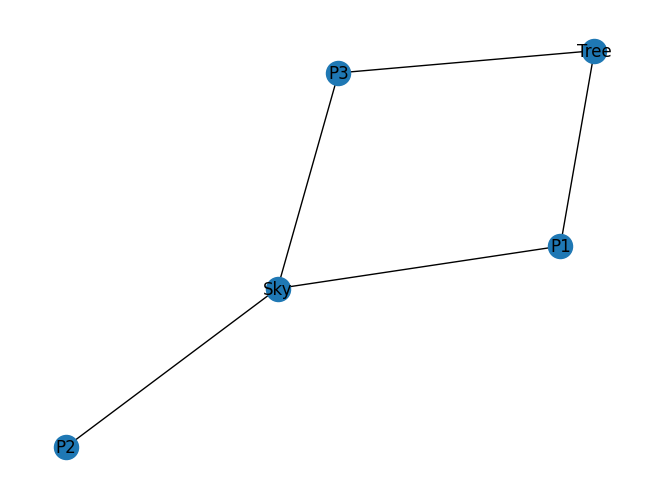

In [8]:

def simrank(G,  beta=0.85, max_iterations=1000):

    # Initialize the simrank matrix
    m = nx.to_numpy_array(G)
    t = np.zeros(len(m))
    old = np.zeros(len(m))
    old[0] = 1
    old = np.transpose(np.asmatrix(old))
   
    t[0] = 1 - beta
    columns = []
    for c in m:
        s = np.sum(c)
        c_n = c * beta / s + t
        columns.append(c_n)

    m = np.column_stack(columns)
    m = np.asmatrix(m)

    for i in range(max_iterations):
        new = np.matmul(m, old)
        
        old = new
    return new
 


g = nx.Graph()
g.add_nodes_from(["P1", "P2", "P3", "Sky", "Tree"])
g.add_edges_from([
  ("Sky", "P1" ), ("Sky", "P2" ),  ("Sky", "P3" ),
  ("Tree", "P1" ),  ("Tree", "P3" ),  
])
nx.draw(g, with_labels = True)


sim = simrank(g)
sim2 = nx.pagerank(g, max_iter = 1000, personalization={"P1": 1})


print(sim)
print(sim2)


## Community Detection Algorithm

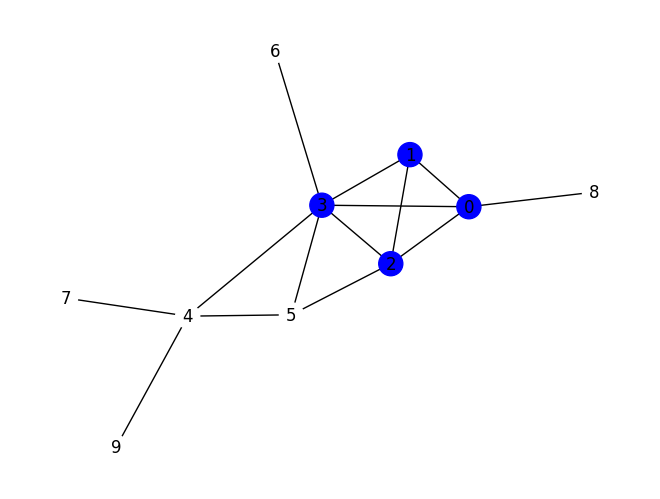

In [9]:
def volume(G, nodes):
    vin = 0.000001
    vout = 0.000001
    for n in G.nodes():
        if n in nodes:
            vin += G.degree(n)
        else:
            vout += G.degree(n)
    return min(vin, vout)

def conductance(G, nodes):
    v = volume(G, nodes)
    c = 0
    for edge in G.edges():
        if (edge[0] in nodes and edge[1] not in nodes) or (edge[0] not in nodes and edge[1] in nodes):
            c += 1
    return c / v

def gen_community(g, c):
    sim = nx.pagerank(g, max_iter = 1000, personalization={0: 1})
    #sort the nodes by their simrank value
    sorted_nodes = sorted(sim.items(), key=lambda x: x[1], reverse=True)

    n = nx.Graph()

    for s in sorted_nodes:
        n.add_node(s[0])
        for node in n.nodes():
            if G.has_edge(node, s[0]):
                n.add_edge(node, s[0])
        
        conductance_value = conductance(G, n.nodes())
        if conductance_value < c:
            return n.nodes()
    return n.nodes()
    
#random graph
G = nx.random_internet_as_graph(10)
community = gen_community(G, 0.5)
#colors nodes, different if node in community
colors = np.zeros((len(G.nodes()), 3)) + 1.0

for node in community:
    colors[node] = [0, 0, 1]

nx.draw(G, with_labels = True, node_color = colors)



## Triangles Counting

3


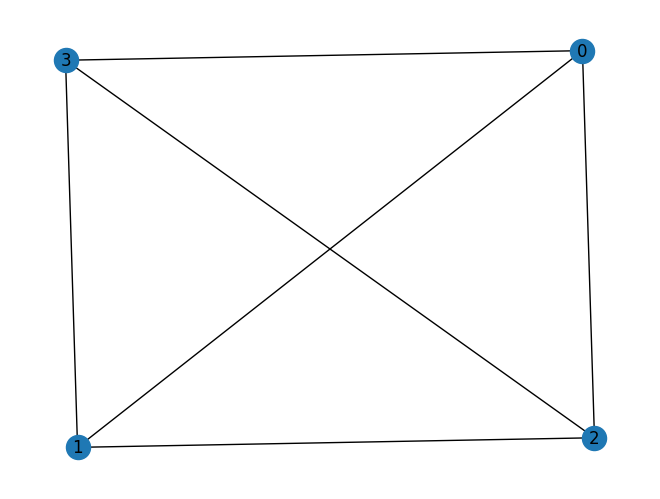

In [6]:
G = nx.complete_graph(4)
nx.draw(G, with_labels = True)

t = nx.triangles(G, 0)
print(t)

## Reachability - Transitive Closure

EdgeView([(0, 7), (0, 4), (0, 2), (0, 3), (0, 8), (0, 9), (0, 1), (0, 5), (0, 6), (7, 2), (7, 3), (7, 4), (7, 9), (7, 1), (7, 8), (7, 6), (7, 5), (1, 3), (1, 5), (1, 9), (1, 4), (1, 8), (1, 6), (1, 2), (3, 4), (3, 5), (3, 9), (3, 8), (3, 2), (3, 6), (4, 8), (4, 2), (4, 5), (4, 6), (4, 9), (2, 9), (2, 6), (2, 8), (2, 5), (5, 8), (5, 6), (5, 9), (8, 6), (8, 9), (6, 9)])

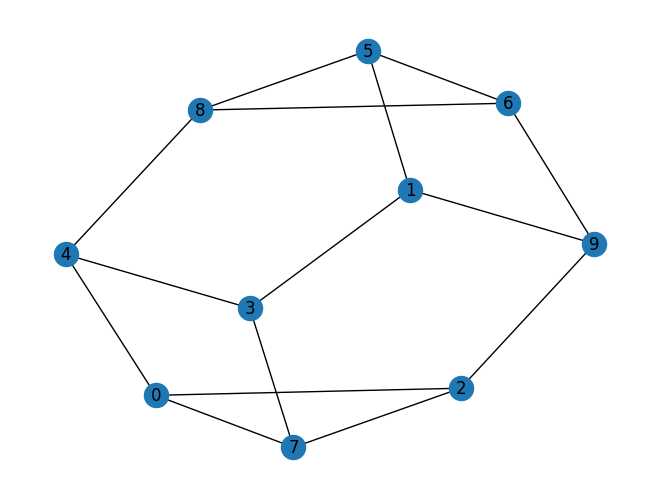

In [7]:
DG = nx.random_regular_graph(3, 10)

nx.draw(DG, with_labels = True)
TC = nx.transitive_closure(DG, reflexive=False)
TC.edges()

# reachabble if the re is an edge between them